In [92]:
from sklearn.svm import SVC # to make comparison with builtin function
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random as rnd


In [93]:
class SVM:
  def __init__(self, kernel=None, C=10.0, max_iter=50, gamma=1):
    
    self.kernel = {'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                   'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X
    self.y = y * 2 - 1
    self.alphas = np.zeros_like(self.y, dtype=float)  # ??Weights used for updating initially we use 0 for all entries
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    for _ in range(self.max_iter):
      for idxM in range(len(self.alphas)):
        idxL = np.random.randint(0, len(self.alphas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.alphas[[idxM, idxL]]
        k0 = 1 - np.sum(self.alphas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.alphas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    idx, = np.nonzero(self.alphas > 1E-15)
    self.b = np.mean((1.0 - np.sum(self.K[idx] * self.alphas, axis=1)) * self.y[idx])
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.alphas, axis=1) + self.b

  def predict(self, X):
    return (np.sign(self.decision_function(X)) + 1) // 2

In [94]:
def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  
  svm_model.fit(X, y)
  z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  plt.title(title)



In [95]:
!pip install xlrd
!pip install openpyxl

In [97]:
col_name = ['Samplecodenumber','ClumpThickness','UniformityofCellSize','UniformityofCellShape',
            'MarginalAdhesion','SingleEpithelialCellSize','BareNuclei',
            'BlandChromatin','NormalNucleoli','Mitoses','Class']

#Read the training data for non-linear separable case
df = pd.read_csv('tumor.csv',names=col_name)
df=df.drop(['Samplecodenumber'], 1)
df= df.drop(['BareNuclei'],1) # reason of dropping this feature is special case 

C:\Anaconda33\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
C:\Anaconda33\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [98]:
cancerdata=df
Benign = cancerdata[(cancerdata.Class == 2) ].sample(240).index
Malignant = cancerdata[(cancerdata.Class == 4) ].sample(240).index
cancer = cancerdata.loc[Benign|Malignant]
cancer = cancer.reset_index(drop=True)
cancer['Class_'] = cancer.Class.map({2:0,4:1})
cancer = cancer.drop(['Class'], 1)
cancer.head(10)

C:\Anaconda33\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  after removing the cwd from sys.path.
C:\Anaconda33\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


,ClumpThickness,UniformityofCellSize,UniformityofCellShape,MarginalAdhesion,SingleEpithelialCellSize,BlandChromatin,NormalNucleoli,Mitoses,Class_
0,5,1,1,1,2,3,1,1,0
1,5,4,4,5,7,3,2,1,0
2,3,1,1,1,2,3,1,1,0
3,6,8,8,1,3,3,7,1,0
4,8,10,10,8,7,9,7,1,1
5,1,1,1,1,2,3,1,1,0
6,2,1,2,1,2,3,1,1,0
7,4,2,1,1,2,2,1,1,0
8,2,1,1,1,2,2,1,1,0
9,5,3,3,3,2,4,4,1,1


In [102]:
y1 = cancer['Class_']
X1 = cancer.drop('Class_', axis=1)

X1= (X1.iloc[:,0:2]).values  # features-- for plotting use --- X1= (X1.iloc[:,0:8]).values
# to train use X1= (X1.iloc[:,0:8]).values

X1.shape
y1=y1.to_numpy()  #labels

X_train= (df.iloc[0:240,0:2]).values
X_test= (df.iloc[240:480,0:2]).values
y_train=(df.iloc[0:240,8:9]).values
Y_test=(df.iloc[240:480,8:9]).values
X1.shape


(480, 2)

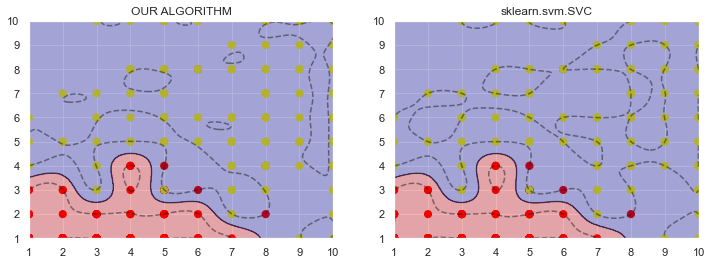

In [103]:
 #### to use this plotting data must not be bigger than 2-D Example-->  DATA.shape should be (number,2)


fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X1, y1, SVM(kernel='rbf', C=10, max_iter=60, gamma=1), axs[0], 'OUR ALGORITHM')
test_plot(X1, y1, SVC(kernel='rbf', C=10, gamma=1), axs[1], 'sklearn.svm.SVC')


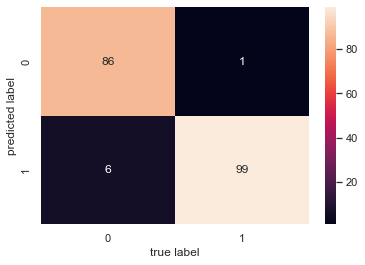

0.9635416666666666

In [90]:

X_train, X_test, y_train, y_test = tts(X1, y1, test_size=0.4, shuffle=True)

a1=SVM(kernel='rbf', C=1.0, max_iter=10, gamma=0.001)
a1.fit(X_train, y_train)
y_fit = a1.predict(X_test)
cm = confusion_matrix(y_test, y_fit)
sns.heatmap(cm.T, annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()
AUC_score = (cm[0][0] + cm[1][1])/(cm[0][1]+cm[1][0]+cm[0][0] + cm[1][1])
AUC_score




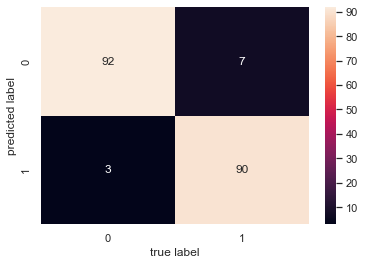

0.9479166666666666

In [74]:
#builtin SVC

b1=svm.SVC(C=1.0, kernel='rbf', gamma=0.001)
b1.fit(X_train, y_train)
y_fit = b1.predict(X_test)
cm = confusion_matrix(y_test, y_fit)
sns.heatmap(cm.T, annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()
AUC_score = (cm[0][0] + cm[1][1])/(cm[0][1]+cm[1][0]+cm[0][0] + cm[1][1])
AUC_score

In [35]:
import seaborn as sns
# sns.scatterplot(x = 'mean area', y = 'mean smoothness', hue = 'target', data = df_cancer_data)


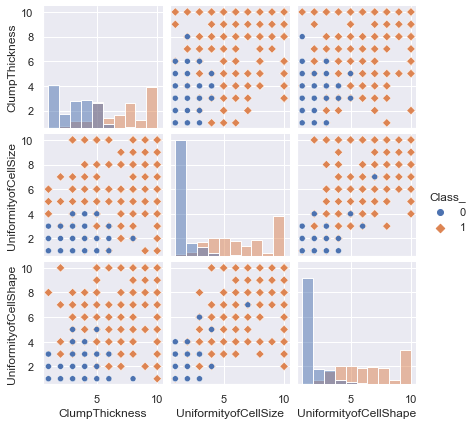

In [36]:
sns.pairplot(cancer, hue='Class_',markers=["o", "D"],diag_kind="hist", height=2,vars = ['ClumpThickness','UniformityofCellSize','UniformityofCellShape'])

In [ ]:
g = sns.PairGrid(X_train,hue='Class_',height=1.5)
g.map(sns.scatterplot)
g.add_legend()


In [ ]:
### after this not using main code, just some doodle ####

In [ ]:
#Divide into train and test !!!!!(NOT USING)
df_train = df.groupby('y', group_keys=False).apply(lambda x:x.sample(frac=0.7))
df_train = df_train.sample(frac=1) # to distribute data randomly
df_test = df[~df.index.isin(df_train.index)]
X_train = np.array(df_train[['X1', 'X2']])
X_test = np.array(np.array(df_test[['X1', 'X2']]))
y_train = np.array(df_train['y'])
y_test = np.array(df_test['y'])

In [74]:
y1 = cancer['Class_']
X1 = cancer.drop('Class_', axis=1)
X1= (X1.iloc[:,0:2]).values

X1.shape
y1=y1.to_numpy()

X_train= (df.iloc[0:240,0:2]).values
X_test= (df.iloc[240:480,0:2]).values
y_train=(df.iloc[0:240,8:9]).values
Y_test=(df.iloc[240:480,8:9]).values
X1.shape

X=X1
y=y1
X.shape
y.shape

(480,)

In [69]:
from cvxopt import matrix, solvers


In [70]:
def gaussian_kernel(x, z, sigma):
    n = x.shape[0]
    m = z.shape[0]
    xx = np.dot(np.sum(np.power(x, 2), 1).reshape(n, 1), np.ones((1, m)))
    zz = np.dot(np.sum(np.power(z, 2), 1).reshape(m, 1), np.ones((1, n)))     
    return np.exp(-(xx + zz.T - 2 * np.dot(x, z.T)) / (2 * sigma ** 2))